# Test of word position extraction for Decoding the Civil War

In [1]:
import numpy as np
import scipy as sp
import astropy as ap
import pandas as pd
import matplotlib
import matplotlib.pyplot as mplplot
%matplotlib inline

The code relies heavily on `scikit-image`!

In [2]:
import skimage
from skimage import io as skimio
from skimage import filters as skimfilt
from skimage import color as skimcolor
from skimage import morphology as skimmorph
from scipy import ndimage as spndimage
from scipy.signal import find_peaks_cwt

## Pipeline adjustable parameters

In [3]:
dataset = 'BOSTON'
piplineParSets = {'DCW' : 
                  {
                      'pageBlurSigma' : 35.0,
                      'lineBlurSigma' : 4.0,
                      'wordBlurSigma' : 10.0,
                      'projectionEdgeTrimPixels' : 10,
                      'linePeakWidthRange' : (5, 30),
                      'wordPeakWidthRange' : (20,175),
                      'exampleSubjectUrl' : 'https://panoptes-uploads.zooniverse.org/production/subject_location/55b05e2a-a14c-40e7-be57-8d3480ec2dc8.jpeg'
                  },
                  'BOSTON': 
                  {
                      'pageBlurSigma' : 5.0,
                      'lineBlurSigma' : 7.0,
                      'wordBlurSigma' : 10.0,
                      'projectionEdgeTrimPixels' : 10,
                      'linePeakWidthRange' : (5, 30),
                      'wordPeakWidthRange' : (20,175),
                      'exampleSubjectUrl' : 'https://panoptes-uploads.zooniverse.org/production/subject_location/1e162b81-715d-495d-9b61-0ef7d9b7e735.jpeg'
                  }
                 }
pipelinePars = piplineParSets[dataset]
exampleSubjectUrl = pipelinePars['exampleSubjectUrl']

## Algorithm
Load an example subject from the DCW dataset

In [4]:
exampleSubject = skimio.imread(exampleSubjectUrl)

Extract the page with text on it.

In [5]:
exampleSubjectGreyScale = skimcolor.rgb2gray(exampleSubject)
level1Threshold = skimfilt.threshold_triangle(exampleSubjectGreyScale)
level1Mask = exampleSubjectGreyScale < level1Threshold
blurredLevel1Mask = skimfilt.gaussian(level1Mask, sigma=pipelinePars['pageBlurSigma'], multichannel=False)

level2TrimLevels = ['hard', 'soft']

level2Threshold = {'hard' : skimfilt.threshold_yen(blurredLevel1Mask), 'soft' : skimfilt.threshold_mean(blurredLevel1Mask)}
level2Mask = { label : blurredLevel1Mask < threshold for label, threshold in level2Threshold.items() }
xProjectedL2Mask = { label : np.sum(mask, axis=1) for label, mask in level2Mask.items() }
yProjectedL2Mask = { label : np.sum(mask, axis=0) for label, mask in level2Mask.items() }
level2TrimMask = {label : np.outer(xProjectedL2Mask[label], yProjectedL2Mask[label]) > 0 for label in level2Mask.keys() }
level2TrimOffsets = {label : (np.nonzero(xProjectedL2Mask[label])[0][0], np.nonzero(yProjectedL2Mask[label])[0][0]) for label in level2Mask.keys() }

trimmedExampleSubjectGreyScale = {label : exampleSubjectGreyScale[mask].reshape(np.count_nonzero(xProjectedL2Mask[label]), 
                                                                                np.count_nonzero(yProjectedL2Mask[label])) 
                                  for label, mask in level2TrimMask.items() }

Attempt to separate words and page by thresholding.

In [6]:
level3Threshold = { label : skimfilt.threshold_isodata(trimmedSubject) for label, trimmedSubject in trimmedExampleSubjectGreyScale.items() }
level3Mask = { label : trimmedExampleSubjectGreyScale[label] < threshold for label, threshold in level3Threshold.items() }
blurredLevel3Mask = {label : skimfilt.gaussian(mask, sigma=pipelinePars['lineBlurSigma'], multichannel=False) for label, mask in level3Mask.items() } 

Find line positions by projecting thresholded image onto Y axis and finding peaks in the projection in the **hard** trimmed image.

In [7]:
trimPix = pipelinePars['projectionEdgeTrimPixels']
yProjectedPixelDensity = np.sum(blurredLevel3Mask['hard'][trimPix:-trimPix,trimPix:-trimPix], axis=1)
xProjectedPixelDensity = np.sum(blurredLevel3Mask['hard'][trimPix:-trimPix,trimPix:-trimPix], axis=0)

lineIndices = find_peaks_cwt(vector=yProjectedPixelDensity, widths=np.arange(*pipelinePars['linePeakWidthRange']))
averageLineSeparation = np.average(np.diff(lineIndices))

Now locate likely words on each line.

In [23]:
wordIndices = []
wordChangePoints = []
meanWordChangePoints = []
segmentXProjections = []
for lineNumber, lineIndex in enumerate(lineIndices) :
    segment = level3Mask['hard'][max(0, int(lineIndex - averageLineSeparation/2)) : int(lineIndex + averageLineSeparation/2), trimPix:-trimPix]
    segmentXProjections.append(np.sum(skimfilt.gaussian(segment > 0, sigma=pipelinePars['wordBlurSigma'], multichannel=False), axis=0))
    superThresholdIndices = segmentXProjections[-1] > 0.1*np.amax(segmentXProjections[-1]) 
    segmentXProjections[-1] = 10*superThresholdIndices.astype(int)
    wordChangePoints.append(np.where(segmentXProjections[-1][:-1] != segmentXProjections[-1][1:]))
    meanWordChangePoints.append(wordChangePoints[-1][:-1] + wordChangePoints[-1][1:])
    print(type(wordChangePoints[-1]), np.array(wordChangePoints[-1]), wordChangePoints[-1][:-1] + wordChangePoints[-1][1:], sep='\n')
    wordIndices.append(find_peaks_cwt(vector=segmentXProjections[-1], 
                                      widths=np.arange(*pipelinePars['wordPeakWidthRange'])).tolist()
                      )

<class 'tuple'>
[[61]]
()
<class 'tuple'>
[[  51  170  186  293  315  355  377  526  545  628  643  711  720  868
   887  981 1001 1051 1066 1150 1167 1210]]
()
<class 'tuple'>
[[  35  119  152  288  311  365  383  463  488  632  645  841  845  945
   959 1167 1171 1234]]
()
<class 'tuple'>
[[  38  154  174  293  297  477  501  556  570  623  641  744  761  823
   847  928  957 1074 1092 1142 1154 1251]]
()
<class 'tuple'>
[[ 35  85 106 191 220 302 325 449 475 576 590 644 662 689]]
()
<class 'tuple'>
[[  23  108  161  172  283  303  395  428  595  618  772  790  846  866
   910  948 1033 1048 1229]]
()
<class 'tuple'>
[[  22   46   92  111  223  246  285  307  426  446  499  522  602  631
   686  733  926  949 1076 1097]]
()
<class 'tuple'>
[[  46  337  384  396  438  552  568  644  663  788  803  997 1016 1060
  1082 1256]]
()
<class 'tuple'>
[[  38  233  264  319  328  379  403  444  476  921  953  998 1026 1121
  1163 1230]]
()
<class 'tuple'>
[[  40  143  172  244  270  472  499  9

Assemble the X and Y coordinates of all detected words for all lines.

In [9]:
wordXIndices = np.concatenate(np.array(wordIndices))
wordYIndices = np.concatenate(np.array([[lineIndex]*len(lineWordIndices) for lineIndex, lineWordIndices in zip(lineIndices, wordIndices)]))

## Intermediate Result Plots

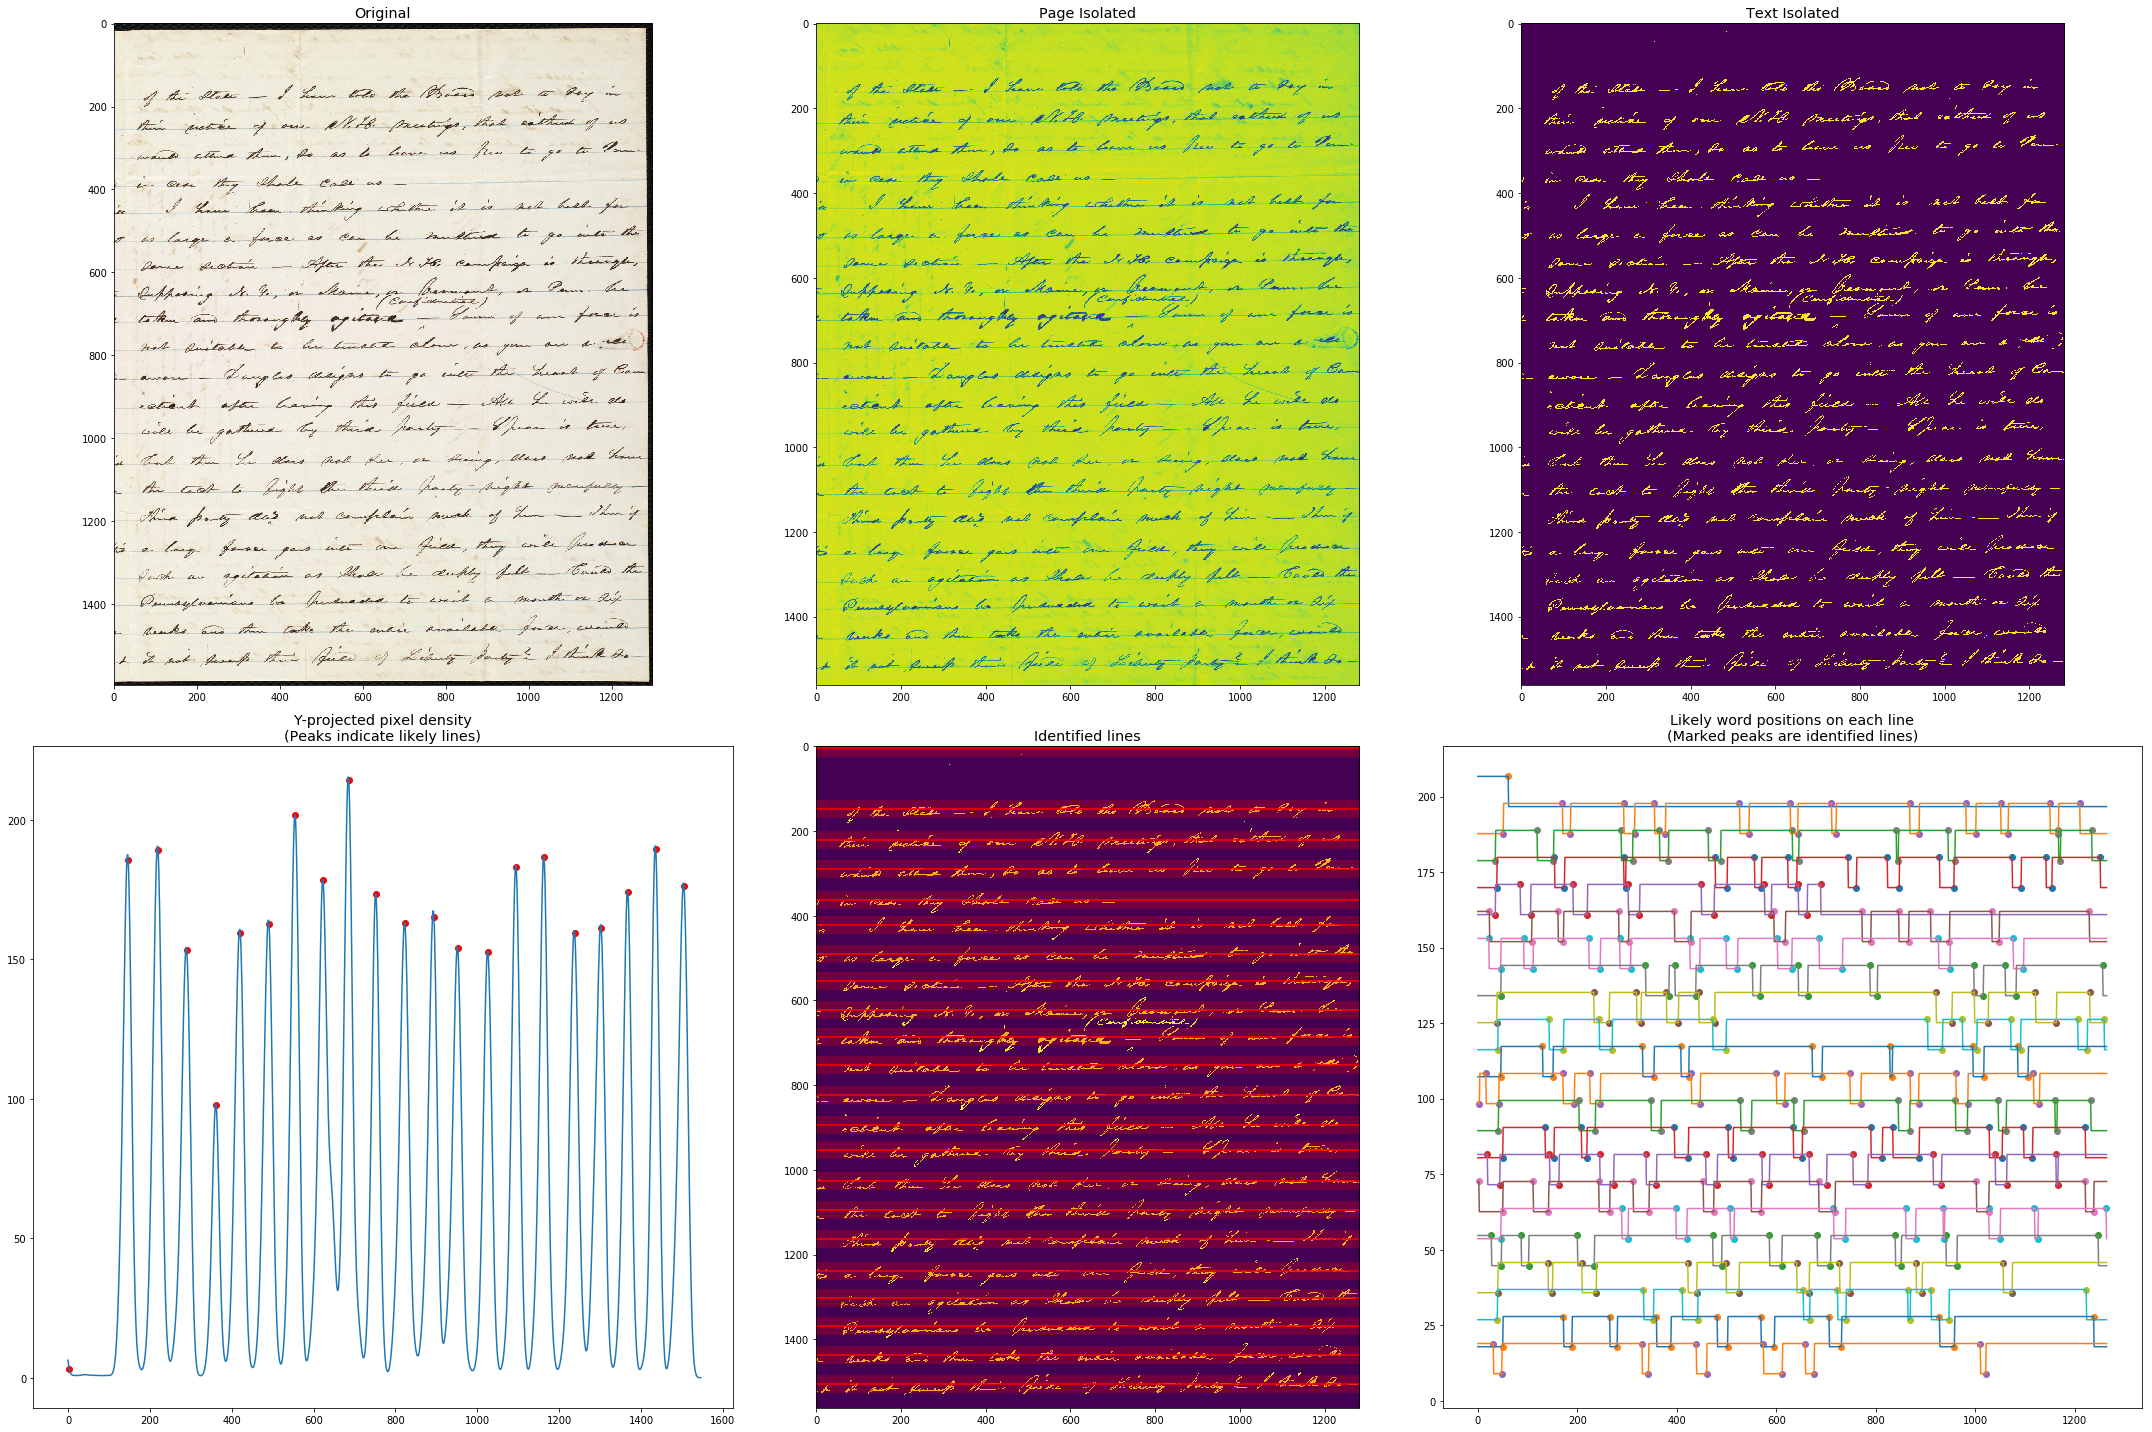

In [13]:
subjectFigure, subjectAxes = mplplot.subplots(figsize=(30, 20), ncols=3, nrows=2)

# plot the original image
originalFigure = subjectAxes.flatten()[0].imshow(exampleSubject)
subjectAxes.flatten()[0].set_title('Original', fontsize='x-large')

# plot a trimmed luminance version of the image 
trimmedExampleSubjectFigure = subjectAxes.flatten()[1].imshow(trimmedExampleSubjectGreyScale['soft'])
subjectAxes.flatten()[1].set_title('Page Isolated', fontsize='x-large')

# plot a trimmed image thresholded to enhance word-page contrast
trimmedExampleSubjectFigure = subjectAxes.flatten()[2].imshow(level3Mask['soft'])
subjectAxes.flatten()[2].set_title('Text Isolated', fontsize='x-large')

# Plot the pixel intensiy projected onto the Y-direction - Peaks indicate likely lines
subjectAxes.flatten()[3].plot(np.arange(len(yProjectedPixelDensity)), yProjectedPixelDensity)
subjectAxes.flatten()[3].scatter(lineIndices, yProjectedPixelDensity[lineIndices], c='r')
subjectAxes.flatten()[3].set_title('Y-projected pixel density\n(Peaks indicate likely lines)', fontsize='x-large')

# Overplot likely line positions on trimmed image
trimmedExampleSubjectFigure = subjectAxes.flatten()[4].imshow(level3Mask['soft'])
subjectAxes.flatten()[4].set_title('Identified lines', fontsize='x-large')
executed = all(subjectAxes.flatten()[4].axhline(lineIndex + (level2TrimOffsets['hard'][1] - level2TrimOffsets['soft'][1]), c='r') for lineIndex in lineIndices)
executed = all(subjectAxes.flatten()[4].axhline(lineIndex + (level2TrimOffsets['hard'][1] - level2TrimOffsets['soft'][1]), c='r', lw=averageLineSeparation/4, alpha=0.25) for lineIndex in lineIndices)

# Plot the projected line-wise pixel intensity and the extracted word positions (peaks)
for lineNumber, (segmentXProjection, 
                 wordIndexList, 
                 wordChangePointList, 
                 meanWordChangePointList) in enumerate(zip(segmentXProjections, wordIndices, wordChangePoints, meanWordChangePoints)) :
    lineTailNumber = len(segmentXProjections) - lineNumber
    subjectAxes.flatten()[5].plot(np.arange(len(segmentXProjection)), segmentXProjection+(lineTailNumber*averageLineSeparation/8))
    subjectAxes.flatten()[5].scatter(wordIndexList, (segmentXProjection+(lineTailNumber*averageLineSeparation/8))[wordIndexList], marker='+')
    subjectAxes.flatten()[5].scatter(wordChangePointList, (segmentXProjection+(lineTailNumber*averageLineSeparation/8))[wordChangePointList], marker='o')
    subjectAxes.flatten()[5].scatter(meanWordChangePointList, (segmentXProjection+(lineTailNumber*averageLineSeparation/8))[meanWordChangePointList], marker='o')
subjectAxes.flatten()[5].set_title('Likely word positions on each line\n(Marked peaks are identified lines)', fontsize='x-large')

mplplot.tight_layout()

## Final Results!
Overplot the extracted word coordinates on the page.

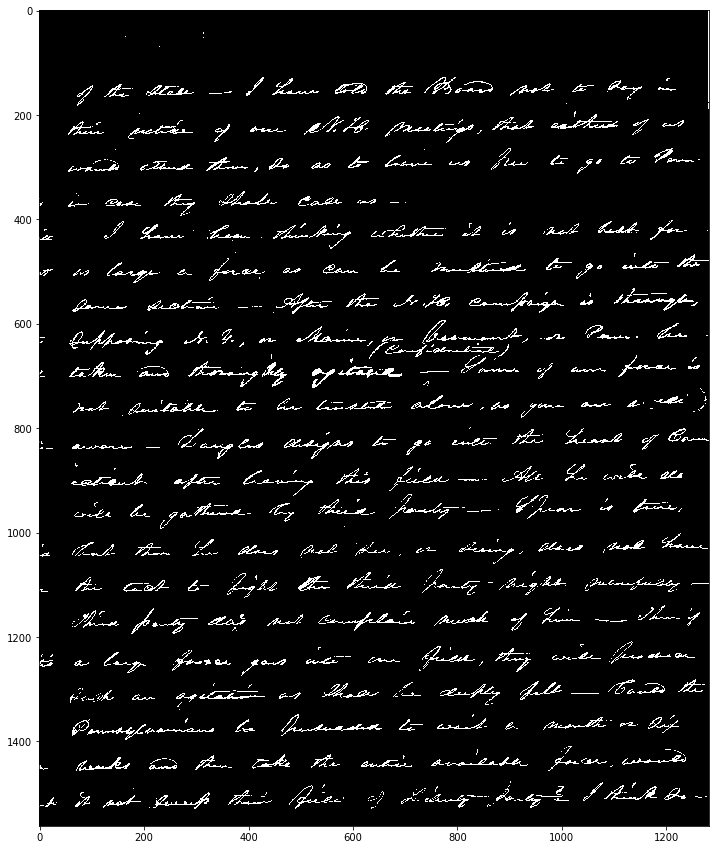

In [11]:
resultFigure = mplplot.figure(figsize=(15, 15))
resultsAxes = resultFigure.add_subplot(111)
resultsAxes.imshow(level3Mask['soft'], cmap='gray')
resultsAxes.scatter(wordXIndices + (level2TrimOffsets['hard'][0] - level2TrimOffsets['soft'][0]), wordYIndices + (level2TrimOffsets['hard'][1] - level2TrimOffsets['soft'][1]), c='r')